# dcurves Tutorial

In [ ]:
!python --version

Install dcurves On The Terminal/Command Line

In [ ]:
!pip install dcurves

## Check dcurves version

In [ ]:
import dcurves
print(dcurves.__version__)

Install dcurves Functions

In [ ]:
from dcurves import dca, plot_graphs

Import Other Packages Used In This Tutorial

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import lifelines
# Display plots in notebook
%matplotlib inline 

Import Cancer Simulation Dataset

In [ ]:
df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')

Create A Generalized Linear Model

In [ ]:
mod1 = sm.GLM.from_formula('cancer ~ famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod1_results = mod1.fit()

mod1_results.summary()

Run DCA With Cancer Outcome and Famhistory Predictor/Model

In [ ]:
dca_famhistory_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory']
    )

plot_graphs(
    plot_df=dca_famhistory_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

Run DCA With Cancer Outcome and Famhistory Predictor/Model with Abridged Thresholds

In [ ]:
dca_famhistory2_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory'],
        thresholds=np.arange(0, 0.36, 0.01),
    )

plot_graphs(
    plot_df=dca_famhistory2_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

Run Multivariate Model and Print Model Summary

In [ ]:
mod2 = sm.GLM.from_formula('cancer ~ marker + age + famhistory', data=df_cancer_dx, family=sm.families.Binomial())
mod2_results = mod2.fit()

mod2_results.summary()

Following 3 Steps Coming Soon! 
- build multivariable logistic regression model
- summarize model
- add predicted values from model to data set

Run DCA on Multivariable Model

In [ ]:
dca_multi_df = \
    dca(
        data=df_cancer_dx,
        outcome='cancer',
        modelnames=['famhistory', 'cancerpredmarker'],
        thresholds=np.arange(0,0.36,0.01)
    )

plot_graphs(
    plot_df=dca_multi_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green', 'orange']
)

Smooth #1

In [ ]:
# Coming Soon

Smooth #2

In [ ]:
# Coming Soon

Published Model

In [ ]:
df_cancer_dx['logodds_brown'] = 0.75 * df_cancer_dx['famhistory'] + 0.26*df_cancer_dx['age'] - 17.5
df_cancer_dx['phat_brown'] = np.exp(df_cancer_dx['logodds_brown']) / (1 + np.exp(df_cancer_dx['logodds_brown']))

dca_pub_model_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['phat_brown'],
      thresholds=np.arange(0,0.36,0.01),
  )

plot_graphs(
    plot_df=dca_pub_model_df,
    y_limits=[-0.05, 0.2],
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green']
)

Joint Calculations

In [ ]:
df_cancer_dx['high_risk'] = np.where(df_cancer_dx['risk_group'] == "high", 1, 0)

df_cancer_dx['joint'] = np.where((df_cancer_dx['risk_group'] == 'high') |
                                 (df_cancer_dx['cancerpredmarker'] > 0.15), 1, 0)

df_cancer_dx['conditional'] = np.where((df_cancer_dx['risk_group'] == "high") |
                                       ((df_cancer_dx['risk_group'] == "intermediate") &
                                        (df_cancer_dx['cancerpredmarker'] > 0.15)), 1, 0)


Perform DCA On Joint Data

In [ ]:
  dca_joint_df = \
      dca(
          data=df_cancer_dx,
          outcome='cancer',
          modelnames=['high_risk', 'joint', 'conditional'],
          thresholds=np.arange(0, 0.5, 0.01)
      )
  
  plot_graphs(
      plot_df=dca_joint_df,
      graph_type='net_benefit',
      y_limits=[-0.05, 0.2],
      color_names=['red', 'blue', 'green', 'orange', 'brown']
  )

Run DCA On a Simple Harms Per Model Case

In [ ]:
dca_harm_simple_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['marker'],
      thresholds=np.arange(0, 0.36, 0.01),
      harm={'marker': 0.0333},
      models_to_prob=['marker']
  )

plot_graphs(
    plot_df=dca_harm_simple_df,
    graph_type='net_benefit',
    color_names=['red', 'blue', 'green'],
    y_limits=[-0.05, 0.15]
)

Run DCA On a Harms Per Model Case

In [ ]:
harm_marker = 0.0333
df_cancer_dx
harm_conditional = (df_cancer_dx['risk_group'] == "intermediate").mean() * harm_marker
# df_cancer_dx['risk_group']

dca_harm_df = \
  dca(
      data=df_cancer_dx,
      outcome='cancer',
      modelnames=['risk_group'],
      models_to_prob=['risk_group'],
      thresholds=np.arange(0, 0.36, 0.01),
      harm={'risk_group': harm_conditional}
  )

plot_graphs(
    plot_df=dca_harm_df,
    graph_type='net_benefit',
    y_limits=[-0.05, 0.2],
    color_names=['red', 'blue', 'green']
)

In [ ]:
harm_conditional

/Users/porwals/Library/Caches/pypoetry/virtualenvs/dcurves-u9i8Mx-r-py3.9/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/porwals/Library/Caches/pypoetry/virtualenvs/dcurves-u9i8Mx-r-py3.9/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/porwals/Library/Caches/pypoetry/virtualenvs/dcurves-u9i8Mx-r-py3.9/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/porwals/Library/Caches/pypoetry/virtualenvs/dcurves-u9i8Mx-r-py3.9/lib/python3.9/site-p

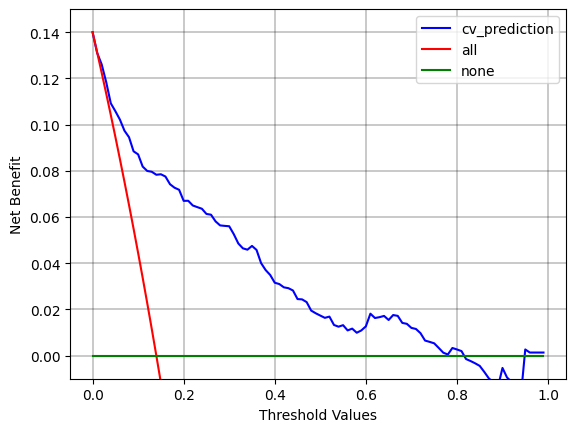

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import log_loss
import statsmodels.api as sm
import dcurves

random.seed(112358)

df_cancer_dx = \
    pd.read_csv(
        "https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv"
    )

# Create a 10-fold cross validation set
cv = RepeatedKFold(n_splits=10, n_repeats=25, random_state=112358)

# Define the formula (make sure the column names in your DataFrame match these)
formula = 'cancer ~ marker + age + famhistory'

# Create cross-validation object
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=112358)

# Placeholder for predictions
cv_predictions = []

# Perform cross-validation
for train_index, test_index in rkf.split(df_cancer_dx):
    # Split data into training and test sets
    train, test = df_cancer_dx.iloc[train_index], df_cancer_dx.iloc[test_index]

    # Fit the model
    model = sm.Logit.from_formula(formula, data=train).fit(disp=0)

    # Make predictions on the test set
    test['cv_prediction'] = model.predict(test)

    # Store predictions
    cv_predictions.append(test[['patientid', 'cv_prediction']])

# Concatenate predictions from all folds
df_predictions = pd.concat(cv_predictions)

# Calculate mean prediction per patient
df_mean_predictions = df_predictions.groupby('patientid')['cv_prediction'].mean().reset_index()

# Join with original data
df_cv_pred = pd.merge(df_cancer_dx, df_mean_predictions, on='patientid', how='left')

# Decision curve analysis
# Generate net benefit score for each threshold value
df_dca_cv = dcurves.dca(
        data=df_cv_pred, modelnames=['cv_prediction'], outcome='cancer'
    )
# Plot DCA curves
dcurves.plot_graphs(plot_df=df_dca_cv, graph_type='net_benefit', y_limits=[-0.01, 0.15], color_names=['blue', 'red', 'green'])

In [ ]:
df_cv_pred